# CSCI 5561 Homework 1 (5% of the overall grade)

The goal of this assignment is to give you a quick start to _hands-on_ computer vision! We will implement a couple of basic functions which are available in most computer vision libraries. You will need to implement them and visually compare against the opencv implementation. You are welcome to use any external material and are encouraged to go deeper using some of the excellent tutorials out there (for example, [this one](https://colab.research.google.com/github/farrokhkarimi/OpenCV/blob/master/Getting_Started_with_OpenCV.ipynb)).

This homework will be graded according to the following honor code:
* You will make an honest attempt and work on the assignment until you are satisfied with the output of your functions and are comfortable with the underlying knowledge. When you reach that point, you can submit it to receive full credit.
* If you copy/paste code from the internet, AI code assistants etc., this constitutes cheating. The penaly is you don't learn and you will probably have a very hard time with the later assignments (they will use this information and will be harder). If your tendency is to go down this path, you should probably not take this course

_By attempting this assignment, you agree to the code above._

**Submission Deadline**

* By Friday Sept 19, midnight: Full credit
* By Sunday Sept 21, midnight: Full credit if you need DRC accomodations or have a valid excuse (which usually means doctor's note). Otherwise you get 75% of the grade. No late submissions beyond this point.

In [1]:
# first we start by importing necessary libraries
import os
import numpy as np
import cv2
from skimage import io
import matplotlib.pyplot as plt

# downloading sample images
if not os.path.exists('m-logo.png'):
    !gdown 1IYb3tNH9TemHmrl1ok_hM7-ZU2aYWhYV -O m-logo.png
if not os.path.exists('minnesota.png'):
    !gdown 10-KQUdz9htcfuL1wZKMVQrob3fUmlbpk -O minnesota.png
if not os.path.exists('usbank-stadium.png'):
    !gdown 1mC1PHxxPeFFYnU5AQMmzpaPTEPcFRUO4 -O usbank-stadium.png

## Bilinear interpolation
Image interpolation is a basic operation in digital image manipulation. It is useful when we need to access the value at an arbitary (e.g. non-interger) coordinate for example when we scale or rotate an image.
In this problem, first we will apply [bilinear interpolation](https://en.wikipedia.org/wiki/Bilinear_interpolation)to scale up and down the M logo:  
![M logo](https://docs.google.com/uc?export=download&id=1IYb3tNH9TemHmrl1ok_hM7-ZU2aYWhYV)


You are expected to implement the function `my_bilinear_interpolate_point(img, point)`

**Input:**
- `img`: input image in size $H \times W \times 3$
- `point`: query point $(x, y)$ in pixel coordinates. Note: In the case where the point is outside the image, just return $\mathbf{0}$

**Output:**
- `dst`: a 3-vector of the interpolated pixel value


You can visually check your implementation by running the following code block. Your result should look similar to the first column (OpenCV resize with bilinear interpolation), not the second column (OpenCV resize with nearest neighbor interpolation).

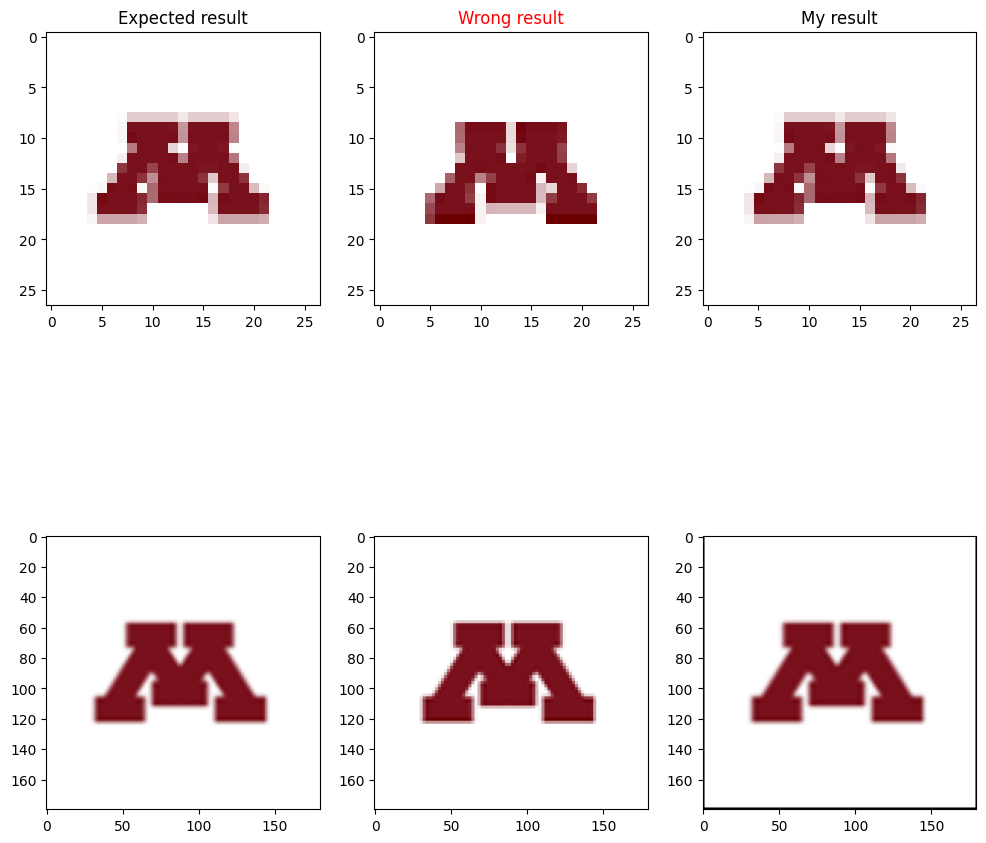

In [2]:
from math import floor, ceil
def my_bilinear_interpolate_point(img, point):
    ############################################################################
    # TODO: Implement your bilinear interpolation function for a single point
    #
    # Arguments
    # ----------
    # img: (H, W, 3)
    #       Input image
    # point: (2,)
    #       The query point (x, y) to sample the image at
    #
    # Return
    # -------
    # dst: (3,)
    #       The interpolated value for the query point
    ############################################################################
    # Replace the next line with your code
    x, y = point[0], point[1]
    x1, x2 = floor(x), ceil(x)
    y1, y2 = floor(y), ceil(y)

    H, W = img.shape[0], img.shape[1]
    # query point out of bounds
    if x1 < 0 or x2 >= W or y1 < 0 or y2 >= H:
        return 0

    Q11, Q12 = img[y1,x1], img[y2,x1]
    Q21, Q22 = img[y1,x2], img[y2,x2]

    dst = 1/((x2-x1)*(y2-y1))*(Q11*(x2-x)*(y2-y)+Q21*(x-x1)*(y2-y)+Q12*(x2-x)*(y-y1)+Q22*(x-x1)*(y-y1))

    ############################################################################
    #                               END OF YOUR CODE                           #
    ############################################################################
    return dst


def bilinear_interpolate_for_loop(img, points):
    ''' For-loop-based bilinear interpolation
    Arguments
    ----------
    img: (H, W, 3)
          Input image
    points: (N, 2)
          The query points to sample the image at. Each row is a point (x, y)

    Return
    -------
    dst: (N, 3)
          The interpolated value for all query points
    '''
    dst = np.zeros([points.shape[0], img.shape[2]], dtype=img.dtype)
    for i, point in enumerate(points):
        dst[i, :] = my_bilinear_interpolate_point(img, point)
    return dst

m_logo = io.imread('m-logo.png')
rows, cols = m_logo.shape[:2]
test_data = [
    (int(cols * 0.3), int(rows * 0.3)),
    (int(cols * 2), int(rows * 2)),
]

fig, axs = plt.subplots(len(test_data), 3, figsize=(12, 12))
for i, trg_size in enumerate(test_data):
    w, h = trg_size
    sx, sy = cols/w, rows/h

    trg_img = cv2.resize(m_logo, trg_size, interpolation=cv2.INTER_LINEAR)
    axs[i, 0].imshow(trg_img)
    if i == 0:
        axs[i, 0].set_title('Expected result')

    wrong_img = cv2.resize(m_logo, trg_size, interpolation=cv2.INTER_NEAREST)
    axs[i, 1].imshow(wrong_img)
    if i == 0:
        axs[i, 1].set_title('Wrong result', color='r')

    X, Y = np.meshgrid(
        (np.linspace(0.5, w-0.5, w) * sx - 0.5),
        (np.linspace(0.5, h-0.5, h) * sy - 0.5),
    )
    points = np.concatenate([X.reshape([-1,1]), Y.reshape([-1,1])], axis=-1)

    my_img = bilinear_interpolate_for_loop(m_logo.astype(np.float32), points).reshape([h, w, -1]).astype(np.uint8)
    axs[i, 2].imshow(my_img)
    if i == 0:
        axs[i, 2].set_title('My result')
fig.show()

## Vectorized implementation of bilinear interpolation

Explicit loops in Python are usually inefficient. Instead of looping over the pixels and interpolating them one by one, we can optimize our interpolation function by taking advantage of NumPy's vectorization mechanism.


You are expected to implement the function `my_bilinear_interpolate(img, points)`

**Input:**
- `img`: input image in size $H \times W \times 3$
- `points`: $N \times 2$ query points in pixel coordinates, where each row is a point $(x, y)$

**Output:**
- `dst`: $N \times 3$ interpolated pixel values

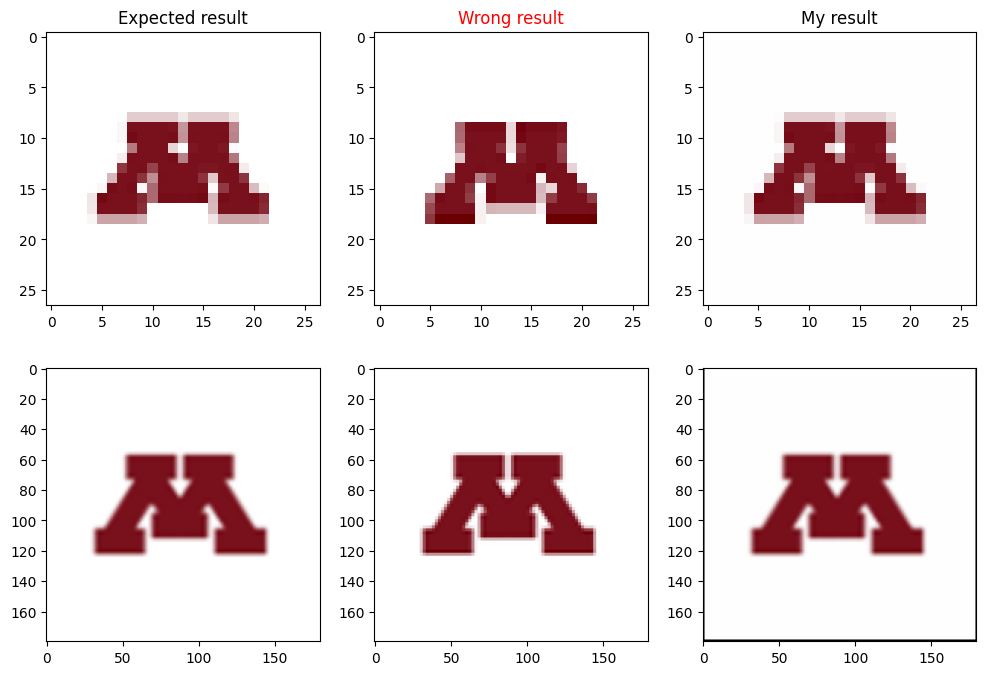

In [3]:
def my_bilinear_interpolate(img, points):
    ############################################################################
    # TODO: Implement your vectorized bilinear interpolation function
    #
    # Arguments
    # ----------
    # img: (H, W, 3)
    #       Input image
    # points: (N, 2)
    #       The query points to sample the image at. Each row is a point (x, y)
    #
    # Return
    # -------
    # dst: (N, 3)
    #       The interpolated value for all query points
    ############################################################################

    X, Y = points[:,0], points[:,1]
    X1 = np.floor(X).astype(np.int64)
    X2 = X1+1
    # X2 = np.ceil(X).astype(np.int64). # why not?
    Y1 = np.floor(Y).astype(np.int64)
    # Y2 = np.ceil(Y).astype(np.int64)
    Y2 = Y1+1

    # out of bound points: delete
    H, W = img.shape[0], img.shape[1]
    filter = (X1 >= 0) & (X2 < W) & (Y1 >= 0) & (Y2 < H)

    # print("x1~y2", X1[0], X2[0], Y1[0], Y2[0])
    # print("x1~y2", X1[-1], X2[-1], Y1[-1], Y2[-1])

    X1 = np.clip(X1, 0, W-1)
    X2 = np.clip(X2, 0, W-1)
    Y1 = np.clip(Y1, 0, H-1)
    Y2 = np.clip(Y2, 0, H-1)
    # print(X1.shape, filter.shape)
    # print(Y1, Y2)
    # print("filter", filter)
    # X1 = np.where(filter, X1, 0)
    # X2 = np.where(filter, X2, 0)
    # Y1 = np.where(filter, Y1, 0)
    # Y2 = np.where(filter, Y2, 0)

    # print(Y2)

    Q11 = img[Y1, X1, :]
    Q12 = img[Y2, X1, :]
    Q21 = img[Y1, X2, :]
    Q22 = img[Y2, X2, :]

    C1 = ((X2-X)/(X2-X1+1e-5))[:, np.newaxis] # last part transposes it to column vector
    C2 = ((X-X1)/(X2-X1+1e-5))[:, np.newaxis]
    fXY1 = C1*Q11 + C2*Q21
    fXY2 = C1*Q12 + C2*Q22

    C3 = ((Y2-Y)/(Y2-Y1+1e-5))[:, np.newaxis]
    C4 = ((Y-Y1)/(Y2-Y1+1e-5))[:, np.newaxis]
    dst = C3*fXY1 + C4*fXY2

    # make all points that should be filtered out 0
    # dst = np.where(filter[:, np.newaxis], dst, 0)

    # Replace the next line with your code
    # dst = np.zeros([points.shape[0], img.shape[2]], dtype=img.dtype)

    ############################################################################
    #                               END OF YOUR CODE                           #
    ############################################################################
    return dst


m_logo = io.imread('m-logo.png')
rows, cols = m_logo.shape[:2]
test_data = [
    (int(cols * 0.3), int(rows * 0.3)),
    (int(cols * 2), int(rows * 2)),
]

fig, axs = plt.subplots(len(test_data), 3, figsize=(12, 8))
for i, trg_size in enumerate(test_data):
    w, h = trg_size
    sx, sy = cols/w, rows/h

    trg_img = cv2.resize(m_logo, trg_size, interpolation=cv2.INTER_LINEAR)
    axs[i, 0].imshow(trg_img)
    if i == 0:
        axs[i, 0].set_title('Expected result')

    wrong_img = cv2.resize(m_logo, trg_size, interpolation=cv2.INTER_NEAREST)
    axs[i, 1].imshow(wrong_img)
    if i == 0:
        axs[i, 1].set_title('Wrong result', color='r')

    X, Y = np.meshgrid(
        (np.linspace(0.5, w-0.5, w) * sx - 0.5),
        (np.linspace(0.5, h-0.5, h) * sy - 0.5),
    )
    points = np.concatenate([X.reshape([-1,1]), Y.reshape([-1,1])], axis=-1)

    my_img = my_bilinear_interpolate(m_logo.astype(np.float32), points).reshape([h, w, -1]).astype(np.uint8)
    axs[i, 2].imshow(my_img)
    if i == 0:
        axs[i, 2].set_title('My result')
fig.show()

## Running time comparison

Let's run the following code block to compare the running times of the two
implementations of bilinear interpolation. Do you have a preference
between these methods?

In [4]:
m_logo = io.imread('m-logo.png')
rows, cols = m_logo.shape[:2]

trg_size = (int(cols * 2), int(rows * 2))
w, h = trg_size
sx, sy = cols/w, rows/h

X, Y = np.meshgrid(
    (np.linspace(0.5, w-0.5, w) * sx - 0.5),
    (np.linspace(0.5, h-0.5, h) * sy - 0.5),
)
points = np.concatenate([X.reshape([-1,1]), Y.reshape([-1,1])], axis=-1)

print('For-loop-based bilinear interpolation:')
%timeit bilinear_interpolate_for_loop(m_logo.astype(np.float32), points)

print('\nVectorized bilinear interpolation:')
%timeit my_bilinear_interpolate(m_logo.astype(np.float32), points)

For-loop-based bilinear interpolation:
1.89 s ± 947 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

Vectorized bilinear interpolation:
10.2 ms ± 1.91 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


Answer: I prefer the vectorized version because it is faster and requires less work from the user

## Image rotation
Now let's apply the bilinear interpolation you have implemented to the image rotation task. For each pixel in the target image, you need to find its location in the source image, and interpolate its pixel value.


You are expected to implement the function `my_rotate_image(img, center, angle)`

**Input:**
- `img`: input image in size $H \times W \times 3$
- `center`: rotation center $(x, y)$ in pixel coordinates
- `angle`: counter-clockwise rotation angle in degrees

**Output:**
- `dst`: $H \times W \times 3$ rotated image. Pixels not from the input image can be filled with any value (e.g., 0)


You can visually check your implementation by running the following code block.

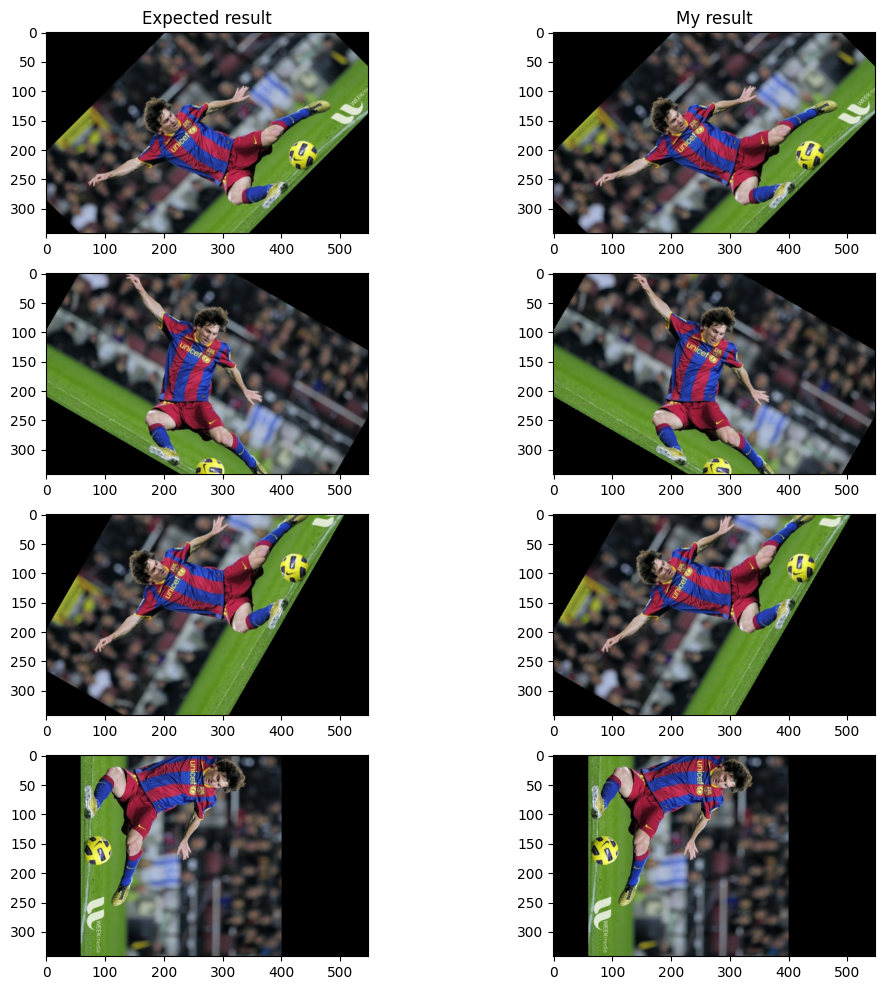

In [5]:
import math
def rotate_image(img, center, angle):
    h, w = img.shape[:2]
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    dst = cv2.warpAffine(img, M, (w, h), flags=cv2.INTER_LINEAR)
    return dst

def get_translation_mat_2d(trans_vec):
    return np.array([[1, 0, trans_vec[0]], [0, 1, trans_vec[1]], [0, 0, 1]])

def my_rotate_image(img, center, angle):
    ############################################################################
    # TODO: Implement your function that rotates an input image
    #
    # Arguments
    # ----------
    # img: (H, W, 3)
    #       Input image
    # center: (2,)
    #       Rotation center (x, y)
    # angle: scalar
    #       Counter-clockwise rotation angle in degrees
    #
    # Return
    # -------
    # dst: (H, W, 3)
    #       Rotated image in the same size as the input image
    ############################################################################

    # Translate image so center is at (0,0)
    center = np.array(center)
    trnsl1 = get_translation_mat_2d(center)
    trnsl2 = get_translation_mat_2d(center * -1)
    angle = math.radians(-angle)               # - angle because we are rotating backwards
    rot = np.array([[math.cos(angle), math.sin(angle), 0], [-math.sin(angle), math.cos(angle), 0], [0, 0, 1]])
    trans = trnsl1 @ rot @ trnsl2

    # get all pixel coords into a list, transform them, then interpolate based on image
    h, w = img.shape[0], img.shape[1]
    pxs = np.array([[i,j,1] for i in range(w) for j in range(h)])
    trans_pxs = trans @ np.transpose(pxs)
    trans_pxs = trans_pxs[:2, :] / trans_pxs[[-1], :] # convert homogeneous coord to heterogenous
    # plt.scatter(trans_pxs[0, :], trans_pxs[1, :])
    # plt.show()
    dst = my_bilinear_interpolate(img, trans_pxs.T).reshape(h, w, 3, order='F')
    dst = dst.astype(int)

    ############################################################################
    #                               END OF YOUR CODE                           #
    ############################################################################
    return dst


messi = io.imread('https://github.com/opencv/opencv/blob/master/samples/data/messi5.jpg?raw=true')
test_data = [
    ((274, 171), 45),
    ((274, 171), -30),
    ((200, 150), 60),
    ((300, 100), -90),
]

fig, axs = plt.subplots(len(test_data), 2, figsize=(12, 12))
for i, (center, angle) in enumerate(test_data):
    trg_img = rotate_image(messi, center, angle)
    axs[i, 0].imshow(trg_img)
    if i == 0:
        axs[i, 0].set_title('Expected result')

    my_img = my_rotate_image(messi.copy(), center, angle)
    axs[i, 1].imshow(my_img)
    if i == 0:
        axs[i, 1].set_title('My result')
fig.show()

## Applying a homography transform to an image

In this question, we will generalize our function in question to more general mappings -- in particular, homographies. The question asks you to generalize your image generation function from a rotation to an arbitary homography which is given as a 3x3 matrix M. To apply the transform to a pixel $(x, y)$ to $(u,v)$, first we generate the homogeneous vector $\vec{x} = [x, y, 1]^T$, then compute $\vec{x'} = M \vec{x} = [x,' y', w']$ then get the normalized coordinates $u = x'/w'$ and $v = y'/w'$.  

You are expected to implement the function `my_warp_perspective(img, M, size)`

**Input:**
- `img`: input image in size $H \times W \times 3$
- `M`: $3 \times 3$ perspective transformation matrix
- `size`: output image size $(W_{out}, H_{out})$

**Output:**
- `dst`: $H_{out} \times W_{out} \times 3$ transformed image


Then we will have some fun and see how to use a homography to deal with perspective distortion in images. Specifically, we will turn the Vikings stadium into a Gophers one! Have fun.

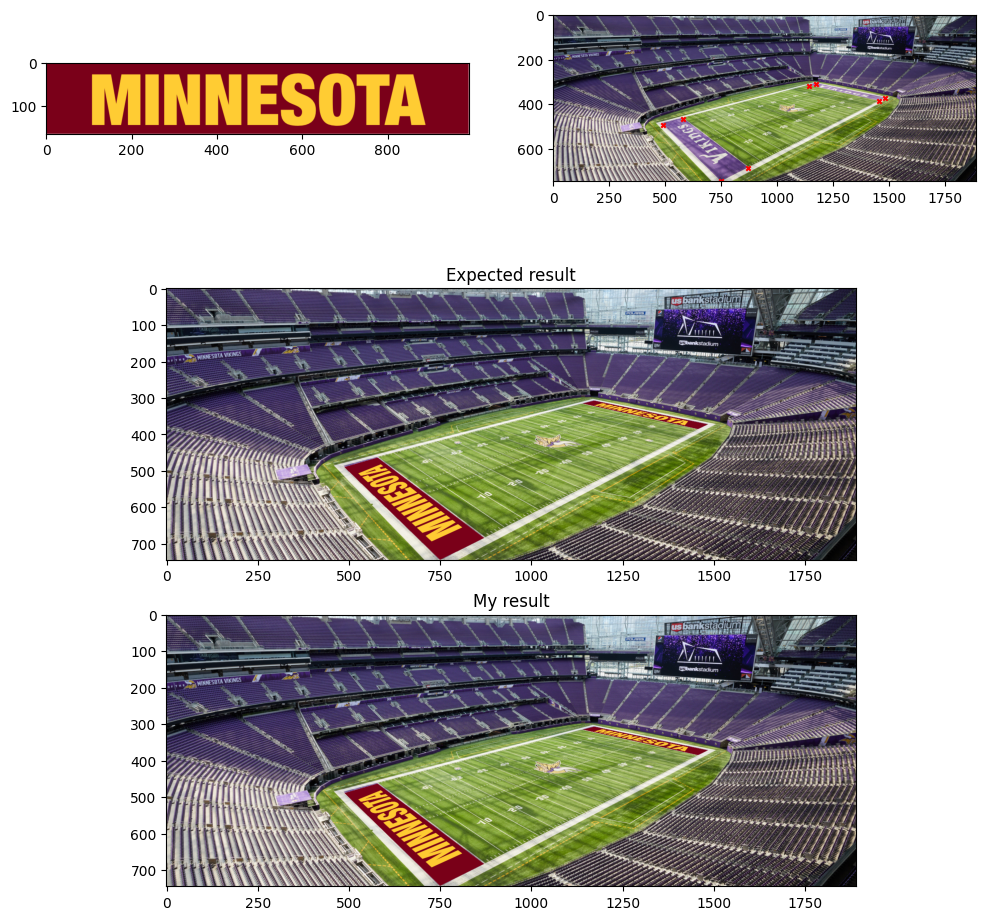

In [6]:
def my_warp_perspective(img, M, size):
    ############################################################################
    # TODO: Implement your function that applies perspective transformation to
    # an image
    #
    # Arguments
    # ----------
    # img: (H, W, 3)
    #       Input image
    # M: (3, 3)
    #       Perspective transformation matrix
    # size: (2,)
    #       Output image size (out_W, outH)
    #
    # Return
    # -------
    # dst: (out_H, out_W, 3)
    #       Output image
    ############################################################################

    pxs = np.array([[i,j,1] for i in range(size[0]) for j in range(size[1])])
    trans = np.linalg.inv(M)  # M not invertible!!
    trans_pxs = trans @ np.transpose(pxs)
    trans_pxs = trans_pxs[:2, :] / trans_pxs[[-1], :] # convert homogeneous coord to heterogenous
    dst = my_bilinear_interpolate(img, trans_pxs.T)
    dst = dst.reshape(size[1], size[0], 3, order='F')

    ############################################################################
    #                               END OF YOUR CODE                           #
    ############################################################################
    return dst


src_img = io.imread('minnesota.png')
s_h, s_w = src_img.shape[:2]
src_points = np.asarray([
    [0, 0],
    [s_w-1, 0],
    [0, s_h-1],
    [s_w-1, s_h-1],
], dtype=np.float32)

trg_img = io.imread('usbank-stadium.png')
t_h, t_w = trg_img.shape[:2]
trg_points_list = [
    np.asarray([
        [750, 744],
        [488, 490],
        [871, 684],
        [579, 464],
    ], dtype=np.float32),
    np.asarray([
        [1173, 308],
        [1484, 373],
        [1141, 316],
        [1457, 386],
    ], dtype=np.float32),
]

dst_img = trg_img.copy()
my_img = trg_img.copy()
for trg_points in trg_points_list:
    M = cv2.getPerspectiveTransform(src_points, trg_points) #we will learn how to do this later in the class!

    mask = cv2.warpPerspective(np.ones_like(src_img), M, (t_w, t_h)).astype(bool)
    dst_img[mask] = cv2.warpPerspective(src_img, M, (t_w, t_h))[mask]

    my_mask = my_warp_perspective(np.ones_like(src_img), M, (t_w, t_h)).astype(bool)
    my_img[my_mask] = my_warp_perspective(src_img, M, (t_w, t_h))[my_mask]


fig = plt.figure(figsize=(12, 12))
gs = fig.add_gridspec(3, 2)

ax = fig.add_subplot(gs[0, 0])
ax.imshow(src_img)

ax = fig.add_subplot(gs[0, 1])
ax.imshow(trg_img)
for trg_points in trg_points_list:
    plt.scatter(trg_points[:, 0], trg_points[:, 1], marker='x', c='r', s=10)

ax = fig.add_subplot(gs[1, :])
ax.imshow(dst_img)
ax.set_title('Expected result')

ax = fig.add_subplot(gs[2, :])
ax.imshow(my_img)
ax.set_title('My result')

plt.show()